In [ ]:
!ls

sample_data


**Getting the Environment Set Up**

In [1]:
!pip3 install torch torchvision
!pip3 install -q kaggle

**You have to upload a kaggle.json token here in order to download the dataset.** Then execute the following commands.

---



In [20]:
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [21]:
!kaggle datasets list -s VinBigData

ref                                                                 title                                               size  lastUpdated          downloadCount  
------------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
awsaf49/vinbigdata-original-image-dataset                           VinBigData Original Image Dataset                   24GB  2020-12-31 22:55:47           2904  
corochann/vinbigdata-chest-xray-original-png                        vinbigdata-chest-xray-original-png                  47GB  2021-02-17 05:26:22            515  
xhlulu/vinbigdata-chest-xray-resized-png-1024x1024                  VinBigData Chest X-ray Resized PNG (1024x1024)       7GB  2021-01-04 01:24:24            879  
xhlulu/vinbigdata-chest-xray-resized-png-256x256                    VinBigData Chest X-ray Resized PNG (256x256)       550MB  2021-01-04 01:24:42            537  
awsaf49/vinbigdata-102

In [22]:
!kaggle datasets download -d xhlulu/vinbigdata-chest-xray-resized-png-256x256

 97% 532M/550M [00:11<00:00, 33.5MB/s]
100% 550M/550M [00:11<00:00, 50.1MB/s]


In [23]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [24]:
!unzip ./vinbigdata-chest-xray-resized-png-256x256.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/train/a9f32aee073a0ee7ea94e959ab63885c.png  
  inflating: ./data/train/a9f467688d104d27583ea3b3154b1f30.png  
  inflating: ./data/train/a9f4c9a4971b3877981e09d4a2ac7fc0.png  
  inflating: ./data/train/a9f60e50925ece0b5c00b6bbd9f0825c.png  
  inflating: ./data/train/aa0202259a3cba71d0e72468e2d9c3e2.png  
  inflating: ./data/train/aa08370eb6114a474adfd0accb6a7238.png  
  inflating: ./data/train/aa0a24df022cd97cc1dff4f7ea2131cc.png  
  inflating: ./data/train/aa0b79c06462e126d97b73a15187c9c4.png  
  inflating: ./data/train/aa1203b1ecab0cddec19f07eb68d4dee.png  
  inflating: ./data/train/aa12ea6652b3b8bea37df74e4e127e8f.png  
  inflating: ./data/train/aa161d1deb918990c3e196501a714994.png  
  inflating: ./data/train/aa1758ce7d9f3cb0bbba72d163ffc69a.png  
  inflating: ./data/train/aa17d5312a0fb4a2939436abca7f9579.png  
  inflating: ./data/train/aa1c58360809119ce5c2d081f590c67b.png  
  inflating: ./data/train/aa1ebd488f7f3

In [25]:
!kaggle competitions download vinbigdata-chest-xray-abnormalities-detection -f train.csv

  0% 0.00/1.79M [00:00<?, ?B/s]
100% 1.79M/1.79M [00:00<00:00, 126MB/s]


In [26]:
!unzip train.csv -d ./data/train_csv

Archive:  train.csv.zip
  inflating: ./data/train_csv/train.csv  


In [27]:
!mv ./data/train_csv/train.csv ./data

**Wrangling the Data**

Files with small bounding boxes must be removed both from the labels and from the train folder. Additionally, the bounding boxes must be resized to match the smaller image size dimensions.

In [28]:
import pandas as pd
import os

root = './data'

train_csv = pd.read_csv(root + '/train.csv')
meta_csv = pd.read_csv(root + '/train_meta.csv')

train_csv = train_csv.sort_index()
meta_csv = meta_csv.sort_index()

train_csv = train_csv.sort_values(by="image_id")
meta_csv = meta_csv.sort_values(by="image_id")

temp = train_csv[(train_csv["x_max"] - train_csv["x_min"] < 20)]
temp = train_csv[(train_csv["y_max"] - train_csv["y_min"] < 20)]

if not os.path.exists(root + '/removed'):
    os.makedirs(root + '/removed')

for i, row in temp.iterrows():
  if os.path.exists(root + "/train/" + str(row["image_id"]) + ".png"):
    os.rename(root + "/train/" + str(row["image_id"]) + ".png", root + "/removed/" + row["image_id"] + ".png")
    
ids = [
  "65ad4fb69f36c807fce87e66a1c6533d",
  "74464c6b0f2b89fa3e8d7262571d86c8",
  "9f6515eac1d5043d511068bd757a17e1",
  "a9519035bae20b2267b38445724221a2",
  "c29cec7b8f63ab34b1c88153b3efd4df"
]

for i in ids:
  if os.path.exists(root + "/train/" + str(i) + ".png"):
    os.rename(root + "/train/" + str(i) + ".png", root + "/removed/" + str(i) + ".png")

meta_csv = meta_csv[~(train_csv["x_max"] - train_csv["x_min"] < 20)]
train_csv = train_csv[~(train_csv["x_max"] - train_csv["x_min"] < 20)]
meta_csv = meta_csv[~(train_csv["y_max"] - train_csv["y_min"] < 20)]
train_csv = train_csv[~(train_csv["y_max"] - train_csv["y_min"] < 20)]

train_csv["class_id"] += 1
train_csv["class_name"] = train_csv["class_name"].replace(["No finding"], "No_finding")
train_csv["class_name"] = train_csv["class_name"].replace(["Aortic enlargement"], "Aortic_enlargement")
train_csv["class_name"] = train_csv["class_name"].replace(["Pleural thickening"], "Pleural_thickening")
train_csv["class_name"] = train_csv["class_name"].replace(["Pulmonary fibrosis"], "Pulmonary_fibrosis")
train_csv["class_name"] = train_csv["class_name"].replace(["Lung Opacity"], "Lung_Opacity")
train_csv["class_name"] = train_csv["class_name"].replace(["Other lesion"], "Other_lesion")
train_csv["class_name"] = train_csv["class_name"].replace(["Pleural effusion"], "Pleural_effusion")
train_csv["class_name"] = train_csv["class_name"].replace(["Nodule/Mass"], "Nodule_mass")

train_csv = train_csv[train_csv['image_id'] != "65ad4fb69f36c807fce87e66a1c6533d"]
train_csv = train_csv[train_csv['image_id'] != "74464c6b0f2b89fa3e8d7262571d86c8"]
train_csv = train_csv[train_csv['image_id'] != "9f6515eac1d5043d511068bd757a17e1"]
train_csv = train_csv[train_csv['image_id'] != "a9519035bae20b2267b38445724221a2"]
train_csv = train_csv[train_csv['image_id'] != "c29cec7b8f63ab34b1c88153b3efd4df"]

meta_csv = meta_csv.set_index('image_id')

for index, row in train_csv.iterrows():
  im_id = row['image_id']
  if im_id in meta_csv.index:
    train_csv.loc[index, 'x_min'] = train_csv.loc[index, 'x_min'] / meta_csv.at[im_id, 'dim1']
    train_csv.loc[index, 'y_min'] = train_csv.loc[index, 'y_min'] / meta_csv.at[im_id, 'dim0']
    train_csv.loc[index, 'x_max'] = train_csv.loc[index, 'x_max'] / meta_csv.at[im_id, 'dim1']
    train_csv.loc[index, 'y_max'] = train_csv.loc[index, 'y_max'] / meta_csv.at[im_id, 'dim0']
  else:
    print(im_id)

train_csv.to_csv(root + "/fixed_train.csv")
meta_csv.to_csv(root + "/fixed_meta.csv")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


**Define the Model, Dataset, and Auxilliary Functions**

In [11]:
import os
import numpy as np
import torch
import pandas as pd
from PIL import Image
from torchvision import transforms as T

class VinBigDataset(object):
    """Constructs a Pytorch Dataset object from the
    VinBigData dataset, extracts the pixel array
    objects from the dicom files and extracts labels
    from train.csv.

    Citation:
    https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    Pytorch Official Documentation, Torchvision Intermediate Tutorial
    Object Detection Finetuning Tutorial
    """
    def __init__(self, transforms=None, fname=None, im_size=255):
      self.im_size = im_size
      self.transforms = transforms
      if transforms is None:
        self.transforms = [T.ToTensor()]
      self.root = './data'
      self.train_path = os.path.join(self.root, 'train')
      self.train = list(sorted(os.listdir(self.train_path)))
      if fname is None:
        self.train_labels = pd.read_csv(os.path.join(self.root, 'fixed_train.csv'))
      else:
        self.train_labels = pd.read_csv(os.path.join(self.root, fname))
      self.train_labels = self.train_labels.set_index('image_id')
      temp = self.train_labels.copy(deep=True)
      temp = temp[~temp.index.duplicated(keep='first')]
      self.image_ids = {temp.index[i]: i for i in range(len(temp))}
      self.image_ids_inverse = {i: temp.index[i] for i in range(len(temp))}
      self.class_id_inverse = {}
      
      for cname in self.train_labels["class_name"].unique():
        class_id = self.train_labels.loc[self.train_labels["class_name"] == cname, "class_id"].values[0]
        self.class_id_inverse[class_id] = cname


    def __getitem__(self, idx):
      path = os.path.join(self.train_path, self.train[idx])
      img = Image.open(path)
      for t in self.transforms:
        img = t(img)
      img_id = self.train[idx].split('.')[0]
      target = {}
      boxes = []
      labels = []
      area = []
      for i, row in self.train_labels.loc[img_id].iterrows():
#         print(row)
        xmin = row['x_min'] * self.im_size
        ymin = row['y_min'] * self.im_size
        xmax = row['x_max'] * self.im_size
        ymax = row['y_max'] * self.im_size
        if xmax != xmax:
          xmin = 0
          ymin = 0
          xmax = self.im_size
          ymax = self.im_size
        box = []
        box.append(xmin)
        box.append(ymin)
        box.append(xmax)
        box.append(ymax)
        labels.append(row['class_id'])
        area.append((box[2] - box[0]) * (box[3] - box[1]))
        if not box in boxes:
          boxes.append(box)
                
      #These are required by the Fast RCNN API
      target["iscrowd"] = torch.zeros((len(boxes),), dtype=torch.int64)
      target["boxes"] = torch.as_tensor(boxes, dtype=torch.float32)
      target["labels"] = torch.as_tensor(labels, dtype=torch.int64)
      target["image_id"] = torch.tensor([self.image_ids[img_id]], dtype=torch.int64)
      target["area"] = torch.as_tensor(area, dtype=torch.float32)

      return img, target

    def __len__(self):
      return len(self.train)

In [12]:
import torchvision
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(pretrained=True, num_classes=16):
    """Loads a pretrained model and replaces
    the old heads (which were trained on Coco) with
    ones that have the appropriate number of classes.

    Citation:
    https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    Pytorch Official Documentation, Torchvision Intermediate Tutorial
    Object Detection Finetuning Tutorial
    """
    if(torch.cuda.is_available()):
      device = torch.device("cuda")
      print(device, torch.cuda.get_device_name(0))
    else:
      device= torch.device("cpu")
      print(device)
    
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained)
    in_features_classifier = model.roi_heads.box_predictor.cls_score.in_features
    box_predictor = FastRCNNPredictor(in_features_classifier, num_classes).to(device)
    model.roi_heads.box_predictor = box_predictor

    return model

In [13]:
import os
import sys
import shutil

def create_ground(subset, data, im_size=255):
  try:
    shutil.rmtree('./data/groundtruths')
    print("groundtruths removed")
  except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
  if not os.path.exists('./data/groundtruths'):
      os.makedirs('./data/groundtruths')
      print("groundtruths successfully created")

  for row, target in subset:
#     print(target)
#     print(len(target))
    target = target[0]
    im_id = data.image_ids_inverse[target['image_id'].item()]
    for i in range(len(target["boxes"])):
      cname = data.class_id_inverse[target["labels"][i].item()]
      xmin = target["boxes"][i][0]
      ymin = target["boxes"][i][1]
      xmax = target["boxes"][i][2]
      ymax = target["boxes"][i][3]
#       print(xmin, ymin, xmax, ymax)
#       print(xmin)
      with open("./data/groundtruths/" + str(im_id) + ".txt", "a") as f:
        if xmin != xmin:
          f.write("{} {} {} {} {}\n".format(
            cname,
            0,
            0,
            im_size,
            im_size
          ))
        else: 
          f.write("{} {} {} {} {}\n".format(
            cname,
            xmin,
            ymin,
            xmax - xmin,
            ymax - ymin
          ))

In [14]:
import torch
import os
import sys
import shutil

def measure(targets, outputs, data):
  if not os.path.exists('./data/detections'):
    os.makedirs('./data/detections')
    print('detections successfully created')
  
  for target, output in zip(targets, outputs):
    im_id = data.image_ids_inverse[target["image_id"].item()]
#     print(output)
    for i in range(len(output["boxes"])):
#       print(i)
      with open("./data/detections/" + im_id + ".txt", "a") as f:
        f.write("{} {} {} {} {} {}\n".format(
          data.class_id_inverse[output['labels'][i].item()],
          output['scores'][i],
          output['boxes'][i][0],
          output['boxes'][i][1],
          output['boxes'][i][2] - output['boxes'][i][0],
          output['boxes'][i][3] - output['boxes'][i][1]
        ))

**Training the Model**

In [15]:
import torch
import time
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import os
import shutil
import sys

def train(lr=0.0005, batch_size=4, plt_title="Train Loss", pickle_title="rcnn", TEST=False, load=None):
  """
  Citation:
    https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    Pytorch Official Documentation, Torchvision Intermediate Tutorial
    Object Detection Finetuning Tutorial
  """
  if(torch.cuda.is_available()):
      device = torch.device("cuda")
      print(device, torch.cuda.get_device_name(0))
  else:
      device= torch.device("cpu")
      print(device)

  def collate(batch):
      return tuple(zip(*batch))

  s = time.time()
  
  model = get_model(pretrained=True).to(device)
  dataset = VinBigDataset()
  if plt_title == "Train Loss":
    plt_title +=" lr=" + str(lr) + '.png'
  shuffle = True
  
  if TEST:
    keep_len = math.floor(.05 * len(dataset))
    throwaway = len(dataset) - keep_len

    keep, throwaway = torch.utils.data.random_split(dataset, [keep_len, throwaway])

    dlen = len(keep)
    train_len = math.floor(dlen * 0.8)
    val_len = dlen - train_len

    train, val = torch.utils.data.random_split(keep, [train_len, val_len])
    train_len_2 = math.floor(train_len * 0.8)
    test_len = train_len - train_len_2
    train, test = torch.utils.data.random_split(train, [train_len_2, test_len])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
  else:
    dlen = len(dataset)
    train_len = math.floor(dlen * 0.8)
    val_len = dlen - train_len
    train, val = torch.utils.data.random_split(dataset, [train_len, val_len])
    train_len_2 = math.floor(train_len * 0.8)
    test_len = train_len - train_len_2
    train, test = torch.utils.data.random_split(train, [train_len_2, test_len])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
  
  create_ground(val_loader, dataset)
  
#   print(dataset.image_ids_inverse[dataset[0][1]["image_id"].item()])
  
  
#   test_val = torch.utils.data.Subset(dataset, [i for i in range(0, 16)])
#   test_train = torch.utils.data.Subset(dataset, [i for i in range(0, 16)])
  
#   test_train_loader = DataLoader(test_train, batch_size=2, shuffle=True, collate_fn=collate)
#   test_val_loader = DataLoader(test_val, batch_size=2, shuffle=True, collate_fn=collate)

  print("starting train")
  
  EPOCHS = 5
  itr = 1
  
  losses = []
  losses_val = []
  avg_loss = []
  avg_loss_val = []

  num_itr = 25

  for i in range(EPOCHS):
    model.train()
    for images, targets in train_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss = model(images, targets)
      loss = sum(l for l in loss.values())
      losses.append(loss)
      if itr > num_itr:
        avg_loss.append(sum(losses[itr-num_itr:itr]) / num_itr)
      
      if itr % 10 == 0:
        print(f"Iteration #{itr} loss: {loss.item()}")
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      itr += 1
    lr_scheduler.step()


  torch.save(model, './' + pickle_title)


  model.eval()
  print("Test")
  try:
    shutil.rmtree('./data/detections')
    print("detections removed and recreated")
  except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
  for images, targets in val_loader:
    images = list(image.to(device) for image in images)
    output = model(images)
    outputs = [{k:v.to(device) for k,v in t.items()} for t in output]
    measure(targets, outputs, dataset)
    
    
  print("Time:")
  print(time.time() - s)
  
#   plt.plot(losses)
#   plt.savefig("Losses.png")
  
  plt.figure()
  plt.plot(avg_loss, color='blue', label="train")
  plt.plot(avg_loss_val, color='red', label="validation")
  plt.title(plt_title)
  plt.xlabel("Iteration")
  plt.ylabel("Average Loss")
  plt.savefig(plt_title)
  
      
# train()

You can skip these if the repo is already downlowded. Otherwise, run these commands.

In [16]:
!git clone https://github.com/rafaelpadilla/Object-Detection-Metrics.git

Cloning into 'Object-Detection-Metrics'...
remote: Enumerating objects: 543, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 543 (delta 20), reused 7 (delta 2), pack-reused 500
Receiving objects: 100% (543/543), 10.63 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (242/242), done.


In [17]:
!mv -v ./Object-Detection-Metrics/* ./data/

renamed './Object-Detection-Metrics/aux_images' -> './data/aux_images'
renamed './Object-Detection-Metrics/detections' -> './data/detections'
renamed './Object-Detection-Metrics/detections_rel' -> './data/detections_rel'
renamed './Object-Detection-Metrics/groundtruths' -> './data/groundtruths'
renamed './Object-Detection-Metrics/groundtruths_rel' -> './data/groundtruths_rel'
renamed './Object-Detection-Metrics/_init_paths.py' -> './data/_init_paths.py'
renamed './Object-Detection-Metrics/lib' -> './data/lib'
renamed './Object-Detection-Metrics/LICENSE' -> './data/LICENSE'
renamed './Object-Detection-Metrics/message.txt' -> './data/message.txt'
renamed './Object-Detection-Metrics/paper_survey_on_performance_metrics_for_object_detection_algorithms.pdf' -> './data/paper_survey_on_performance_metrics_for_object_detection_algorithms.pdf'
renamed './Object-Detection-Metrics/pascalvoc.py' -> './data/pascalvoc.py'
renamed './Object-Detection-Metrics/README.md' -> './data/README.md'
renamed '.

**Evaluating the Model**

In [ ]:
%cd ./data/
!ls

/content/data
aux_images
detections
detections_rel
fixed_meta.csv
fixed_train.csv
groundtruths
groundtruths_rel
_init_paths.py
lib
LICENSE
message.txt
paper_survey_on_performance_metrics_for_object_detection_algorithms.pdf
pascalvoc.py
__pycache__
README.md
removed
requirements.txt
results
samples
test
train
train_csv
train.csv
train_meta.csv


In [ ]:
%cd ..

/content


LR=0.003

In [ ]:
%cd ./data/
!python ./pascalvoc.py
%cd ..

/content/data
python3: can't open file './pascalvoc.pyy': [Errno 2] No such file or directory
/content


LR=0.00003

In [ ]:
%cd ./data/
!python ./pascalvoc.py
%cd ..

/content/data


####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                                                                              #
#                                                                                                  #
# PLEASE ACCESS IT ACCESSED AT:                                                                    #
# https://github.com/rafaelpadilla/review_object_detection_metrics                                 #
#                                                                                                  #
# @Article{electronics10030279,                                                                    #
#     author         = {Padilla, Rafael and Passos, Wesley L. and Dias, Tha

LR=0.0003

In [ ]:
%cd ./data/
!python ./pascalvoc.py
%cd ..

/content/data


####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                                                                              #
#                                                                                                  #
# PLEASE ACCESS IT ACCESSED AT:                                                                    #
# https://github.com/rafaelpadilla/review_object_detection_metrics                                 #
#                                                                                                  #
# @Article{electronics10030279,                                                                    #
#     author         = {Padilla, Rafael and Passos, Wesley L. and Dias, Tha

LR=0.0005

In [ ]:
%cd ./data/
!python ./pascalvoc.py
%cd ..

/content/data


####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                                                                              #
#                                                                                                  #
# PLEASE ACCESS IT ACCESSED AT:                                                                    #
# https://github.com/rafaelpadilla/review_object_detection_metrics                                 #
#                                                                                                  #
# @Article{electronics10030279,                                                                    #
#     author         = {Padilla, Rafael and Passos, Wesley L. and Dias, Tha

cuda Tesla P100-PCIE-16GB
cuda Tesla P100-PCIE-16GB
groundtruths removed and recreated
starting train
Iteration #10 loss: 1.6104532480239868
Iteration #20 loss: 1.2971807718276978
Iteration #30 loss: 0.5629605054855347
Iteration #40 loss: 0.2240467667579651
Iteration #50 loss: 0.3608158230781555
Iteration #60 loss: 0.3080262541770935
Iteration #70 loss: 0.2583686113357544
Iteration #80 loss: 0.30938196182250977
Iteration #90 loss: 0.4783269166946411
Iteration #100 loss: 0.4705372750759125
Iteration #110 loss: 0.7035476565361023
Iteration #120 loss: 0.38735589385032654
Test
detections removed and recreated
Time:
63.74286985397339
/content/data


####################################################################################################
#                                                                                                  #
# THE CURRENT VERSION WAS UPDATED WITH A VISUAL INTERFACE, INCLUDING MORE METRICS AND SUPPORTING   #
# OTHER FILE FORMATS.                       

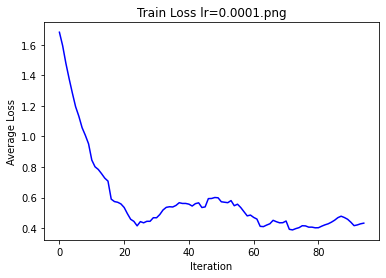

In [ ]:
train(lr=0.001, pickle_title="rcnn1")
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla T4
cuda Tesla T4
groundtruths removed and recreated
starting train
Iteration #10 loss: 0.9594968557357788
Iteration #20 loss: 0.3467597961425781
Iteration #30 loss: 0.40442484617233276
Iteration #40 loss: 0.5433423519134521
Iteration #50 loss: 0.2239585518836975
Iteration #60 loss: 0.21336357295513153
Iteration #70 loss: 0.5086564421653748
Iteration #80 loss: 0.4248337149620056
Iteration #90 loss: 0.2763640582561493
Iteration #100 loss: 0.439378023147583
Iteration #110 loss: 0.23361042141914368
Iteration #120 loss: 0.14820265769958496
Test
detections removed and recreated
Time:
108.627920627594
[Errno 2] No such file or directory: './datay/'
/content
python3: can't open file './pascalvoc.py': [Errno 2] No such file or directory
/


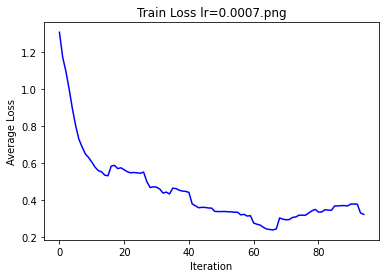

In [ ]:
train(lr=0.0007)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
%cd content

In [ ]:
train(lr=0.0007)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
train(lr=0.0006)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
train(lr=0.0005)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
train(lr=0.0004)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
train(lr=0.0003, pickle_title="rcnn2")
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla P100-PCIE-16GB
cuda Tesla P100-PCIE-16GB
groundtruths removed and recreated
starting train
Iteration #10 loss: 0.8473402261734009
Iteration #20 loss: 0.6789799332618713
Iteration #30 loss: 1.4279818534851074
Iteration #40 loss: 0.1758313775062561
Iteration #50 loss: 0.8473929166793823
Iteration #60 loss: 0.39125627279281616
Iteration #70 loss: 0.47710201144218445
Iteration #80 loss: 0.5752744078636169
Iteration #90 loss: 0.16955211758613586
Iteration #100 loss: 0.20718801021575928
Iteration #110 loss: 0.2792727053165436
Iteration #120 loss: 0.24420978128910065
Iteration #130 loss: 1.3136872053146362
Iteration #140 loss: 0.16258437931537628
Iteration #150 loss: 0.4775371849536896
Iteration #160 loss: 0.9033966064453125
Iteration #170 loss: 0.12270008027553558
Iteration #180 loss: 0.30600276589393616
Iteration #190 loss: 0.2500438988208771
Iteration #200 loss: 0.4518103301525116
Iteration #210 loss: 0.12261028587818146
Iteration #220 loss: 0.14375276863574982
Iteration #230 lo

KeyboardInterrupt: ignored

In [ ]:
%cd content/

/content


cuda Tesla P100-PCIE-16GB
cuda Tesla P100-PCIE-16GB


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



groundtruths removed and recreated
starting train
Iteration #10 loss: 0.6124647855758667
Iteration #20 loss: 0.23637086153030396
Iteration #30 loss: 0.6405553817749023
Iteration #40 loss: 0.4939812123775482
Iteration #50 loss: 0.6205160617828369
Iteration #60 loss: 0.19388890266418457
Iteration #70 loss: 0.48064178228378296
Iteration #80 loss: 0.3177116811275482
Iteration #90 loss: 0.13909359276294708
Iteration #100 loss: 0.323273241519928
Iteration #110 loss: 0.26273810863494873
Iteration #120 loss: 0.5189725160598755
Iteration #130 loss: 0.18081922829151154
Iteration #140 loss: 1.0556031465530396
Iteration #150 loss: 0.2695944905281067
Iteration #160 loss: 0.4378022849559784
Iteration #170 loss: 0.5051328539848328
Iteration #180 loss: 0.29015886783599854
Iteration #190 loss: 1.1009045839309692
Iteration #200 loss: 0.29410141706466675
Iteration #210 loss: 0.8763430118560791
Iteration #220 loss: 0.385029137134552
Iteration #230 loss: 0.13374561071395874
Iteration #240 loss: 0.77929919

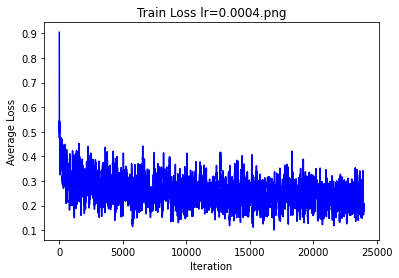

In [ ]:
train(lr=0.0004, pickle_title="rcnn2")
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
train(lr=0.0004, pickle_title="rcnn5", load="rcnn4", batch_size=8)
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla P100-PCIE-16GB
cuda Tesla P100-PCIE-16GB


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 0.8825840950012207
Iteration #20 loss: 0.6662842035293579
Iteration #30 loss: 0.3954567611217499
Iteration #40 loss: 0.4327124357223511
Iteration #50 loss: 0.48286670446395874
Iteration #60 loss: 0.4318042993545532
Iteration #70 loss: 0.47559112310409546
Iteration #80 loss: 0.5625410676002502
Iteration #90 loss: 0.2857723534107208
Iteration #100 loss: 0.5628059506416321
Iteration #110 loss: 0.4426526427268982
Iteration #120 loss: 0.4852752387523651
Iteration #130 loss: 0.6492055654525757
Iteration #140 loss: 0.15710417926311493
Iteration #150 loss: 0.5028811097145081
Iteration #160 loss: 0.3010352849960327
Iteration #170 loss: 0.23395797610282898
Iteration #180 loss: 0.3870163559913635
Iteration #190 loss: 0.16690631210803986
Iteration #200 loss: 0.4691915810108185
Iteration #210 loss: 0.6296383738517761
Iteration #220 loss: 0.4319891035556793
Iteration #230 loss: 0.2978461682796478
Iteration #24

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 1.6254100799560547
Iteration #20 loss: 0.32743704319000244
Iteration #30 loss: 0.22679516673088074
Iteration #40 loss: 0.22893185913562775
Iteration #50 loss: 0.10957025736570358
Iteration #60 loss: 0.2076343297958374
Iteration #70 loss: 0.21886517107486725
Iteration #80 loss: 0.7617487907409668
Iteration #90 loss: 0.4992772340774536
Iteration #100 loss: 0.29048165678977966
Iteration #110 loss: 0.24686464667320251
Iteration #120 loss: 0.6338661909103394
Iteration #130 loss: 0.22740823030471802
Iteration #140 loss: 0.05642003193497658
Iteration #150 loss: 0.6660299897193909
Iteration #160 loss: 0.37461426854133606
Iteration #170 loss: 0.22168433666229248
Iteration #180 loss: 0.3264286518096924
Iteration #190 loss: 0.5784679055213928
Iteration #200 loss: 0.3862294554710388
Iteration #210 loss: 0.3169092833995819
Iteration #220 loss: 0.1354539394378

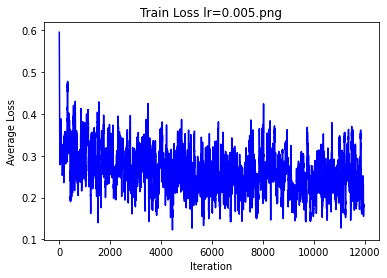

In [31]:
train(lr=0.005, pickle_title="rcnn02", load="rcnn01", batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
train(lr=0.001, pickle_title="rcnn001", load="rcnn02", batch_size=8)
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 0.7554633021354675
Iteration #20 loss: 0.7583385109901428
Iteration #30 loss: 0.4466913640499115
Iteration #40 loss: 0.6881601214408875
Iteration #50 loss: 0.27423250675201416
Iteration #60 loss: 0.4857633113861084
Iteration #70 loss: 0.4528574049472809
Iteration #80 loss: 0.36202725768089294
Iteration #90 loss: 0.19585362076759338
Iteration #100 loss: 0.2277536541223526
Iteration #110 loss: 0.31944549083709717
Iteration #120 loss: 0.4453611969947815
Iteration #130 loss: 0.518513023853302
Iteration #140 loss: 0.38578540086746216
Iteration #150 loss: 0.7603403925895691
Iteration #160 loss: 0.5124025344848633
Iteration #170 loss: 0.5515438914299011
Iteration #180 loss: 0.3416003882884979
Iteration #190 loss: 0.4721944332122803
Iteration #200 loss: 0.5274168252944946
Iteration #210 loss: 0.42052724957466125
Iteration #220 loss: 0.27826452255249023
I

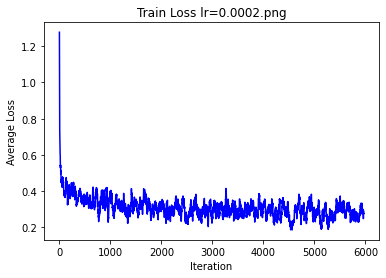

In [20]:
train(lr=0.0002, pickle_title="rcnn02", batch_size=8)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [30]:
import pandas as pd
import os

root = './data'

train_csv = pd.read_csv(root + '/train.csv')
meta_csv = pd.read_csv(root + '/train_meta.csv')

train_csv = train_csv.sort_index()
meta_csv = meta_csv.sort_index()

train_csv = train_csv.sort_values(by="image_id")
meta_csv = meta_csv.sort_values(by="image_id")

temp = train_csv[(train_csv["x_max"] - train_csv["x_min"] < 20)]
temp = train_csv[(train_csv["y_max"] - train_csv["y_min"] < 20)]

if not os.path.exists(root + '/removed'):
    os.makedirs(root + '/removed')

for i, row in temp.iterrows():
  if os.path.exists(root + "/train/" + str(row["image_id"]) + ".png"):
    os.rename(root + "/train/" + str(row["image_id"]) + ".png", root + "/removed/" + row["image_id"] + ".png")
    
ids = [
  "65ad4fb69f36c807fce87e66a1c6533d",
  "74464c6b0f2b89fa3e8d7262571d86c8",
  "9f6515eac1d5043d511068bd757a17e1",
  "a9519035bae20b2267b38445724221a2",
  "c29cec7b8f63ab34b1c88153b3efd4df"
]

for i in ids:
  if os.path.exists(root + "/train/" + str(i) + ".png"):
    os.rename(root + "/train/" + str(i) + ".png", root + "/removed/" + str(i) + ".png")

meta_csv = meta_csv[~(train_csv["x_max"] - train_csv["x_min"] < 20)]
train_csv = train_csv[~(train_csv["x_max"] - train_csv["x_min"] < 20)]
meta_csv = meta_csv[~(train_csv["y_max"] - train_csv["y_min"] < 20)]
train_csv = train_csv[~(train_csv["y_max"] - train_csv["y_min"] < 20)]

train_csv["class_id"] += 1
train_csv["class_name"] = train_csv["class_name"].replace(["No finding"], "No_finding")
train_csv["class_name"] = train_csv["class_name"].replace(["Aortic enlargement"], "Aortic_enlargement")
train_csv["class_name"] = train_csv["class_name"].replace(["Pleural thickening"], "Pleural_thickening")
train_csv["class_name"] = train_csv["class_name"].replace(["Pulmonary fibrosis"], "Pulmonary_fibrosis")
train_csv["class_name"] = train_csv["class_name"].replace(["Lung Opacity"], "Lung_Opacity")
train_csv["class_name"] = train_csv["class_name"].replace(["Other lesion"], "Other_lesion")
train_csv["class_name"] = train_csv["class_name"].replace(["Pleural effusion"], "Pleural_effusion")
train_csv["class_name"] = train_csv["class_name"].replace(["Nodule/Mass"], "Nodule_mass")

train_csv = train_csv[train_csv['image_id'] != "65ad4fb69f36c807fce87e66a1c6533d"]
train_csv = train_csv[train_csv['image_id'] != "74464c6b0f2b89fa3e8d7262571d86c8"]
train_csv = train_csv[train_csv['image_id'] != "9f6515eac1d5043d511068bd757a17e1"]
train_csv = train_csv[train_csv['image_id'] != "a9519035bae20b2267b38445724221a2"]
train_csv = train_csv[train_csv['image_id'] != "c29cec7b8f63ab34b1c88153b3efd4df"]

meta_csv = meta_csv.set_index('image_id')

for index, row in train_csv.iterrows():
  im_id = row['image_id']
  if im_id in meta_csv.index:
    train_csv.loc[index, 'x_min'] = train_csv.loc[index, 'x_min'] / meta_csv.at[im_id, 'dim1']
    train_csv.loc[index, 'y_min'] = train_csv.loc[index, 'y_min'] / meta_csv.at[im_id, 'dim0']
    train_csv.loc[index, 'x_max'] = train_csv.loc[index, 'x_max'] / meta_csv.at[im_id, 'dim1']
    train_csv.loc[index, 'y_max'] = train_csv.loc[index, 'y_max'] / meta_csv.at[im_id, 'dim0']
  else:
    print(im_id)


for index, row in train_csv.iterrows():
  im_id = row['image_id']
  print(row['class_name'])
  if row['class_name'] == 'No_finding':
      if os.path.exists(root + "/train/" + str(im_id) + ".png"):
        os.rename(root + "/train/" + str(im_id) + ".png", root + "/removed/" + str(im_id) + ".png")

meta_csv = train_csv[train_csv['class_name'] != 'No_finding']
train_csv = train_csv[train_csv['class_name'] !=  'No_finding']

print("Train Length: ", len(train_csv))

train_csv.to_csv(root + "/fixed_train.csv")
meta_csv.to_csv(root + "/fixed_meta.csv")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Streaming output truncated to the last 5000 lines.
No_finding
No_finding
Aortic_enlargement
Pleural_thickening
Pleural_thickening
Aortic_enlargement
Aortic_enlargement
No_finding
No_finding
No_finding
No_finding
No_finding
No_finding
Pulmonary_fibrosis
Pleural_thickening
Pulmonary_fibrosis
Pleural_thickening
Pulmonary_fibrosis
Aortic_enlargement
No_finding
No_finding
No_finding
Cardiomegaly
Pulmonary_fibrosis
Cardiomegaly
Cardiomegaly
Aortic_enlargement
Pleural_thickening
Pulmonary_fibrosis
Calcification
Aortic_enlargement
Aortic_enlargement
Other_lesion
Calcification
Lung_Opacity
Nodule_mass
Lung_Opacity
Nodule_mass
Aortic_enlargement
Nodule_mass
Nodule_mass
Pleural_thickening
Pulmonary_fibrosis
Nodule_mass
Calcification
Lung_Opacity
Pleural_thickening
No_finding
No_finding
No_finding
No_finding
No_finding
No_finding
Pleural_thickening
Cardiomegaly
Aortic_enlargement
Aortic_enlargement
Aortic_enlargement
Cardiomegaly
Other_lesion
Cardiomegaly
Aortic_enlargement
Cardiomegaly
Cardiomega

['Nodule_mass' 'Infiltration' 'Lung_Opacity' 'Consolidation'
 'Pleural_thickening' 'ILD' 'Cardiomegaly' 'Pulmonary_fibrosis'
 'Aortic_enlargement' 'Other_lesion' 'Pleural_effusion' 'Calcification'
 'Atelectasis' 'Pneumothorax']


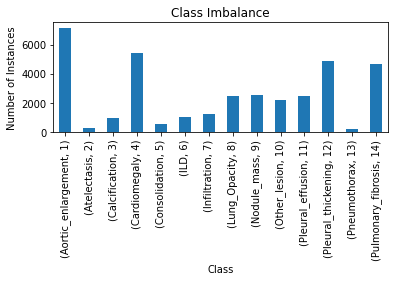

In [28]:
import pandas as pd
import os
import matplotlib.pyplot as plt

data = pd.read_csv(os.path.join("./data/", 'fixed_train.csv'))

plt.figure()
data.pivot_table(index=['class_name', "class_id"], aggfunc='size').plot(kind='bar')
plt.title("Class Imbalance")
plt.ylabel("Number of Instances")
plt.xlabel("Class")
plt.gcf().subplots_adjust(bottom=0.5)
plt.savefig("Classes.png")

print(data['class_name'].unique())

In [62]:
import torch
import time
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import os
import shutil
import sys

def train(lr=0.0005, batch_size=4, plt_title="Train Loss", pickle_title="rcnn", TEST=False, load=None):
  """
  Citation:
    https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    Pytorch Official Documentation, Torchvision Intermediate Tutorial
    Object Detection Finetuning Tutorial
  """
  if(torch.cuda.is_available()):
      device = torch.device("cuda")
      print(device, torch.cuda.get_device_name(0))
  else:
      device= torch.device("cpu")
      print(device)

  def collate(batch):
      return tuple(zip(*batch))

  s = time.time()
  
  model = get_model(pretrained=True, num_classes=15).to(device)
  dataset = VinBigDataset()
  if plt_title == "Train Loss":
    plt_title +=" lr=" + str(lr) + '.png'
  shuffle = True
  
  if TEST:
    keep_len = math.floor(.05 * len(dataset))
    throwaway = len(dataset) - keep_len

    keep, throwaway = torch.utils.data.random_split(dataset, [keep_len, throwaway])

    dlen = len(keep)
    train_len = math.floor(dlen * 0.8)
    val_len = dlen - train_len

    train, val = torch.utils.data.random_split(keep, [train_len, val_len])
    train_len_2 = math.floor(train_len * 0.8)
    test_len = train_len - train_len_2
    train, test = torch.utils.data.random_split(train, [train_len_2, test_len])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
  else:
    dlen = len(dataset)
    train_len = math.floor(dlen * 0.8)
    val_len = dlen - train_len
    train, val = torch.utils.data.random_split(dataset, [train_len, val_len])
    train_len_2 = math.floor(train_len * 0.8)
    test_len = train_len - train_len_2
    train, test = torch.utils.data.random_split(train, [train_len_2, test_len])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
  
  create_ground(val_loader, dataset)
  
#   print(dataset.image_ids_inverse[dataset[0][1]["image_id"].item()])
  
  
#   test_val = torch.utils.data.Subset(dataset, [i for i in range(0, 16)])
#   test_train = torch.utils.data.Subset(dataset, [i for i in range(0, 16)])
  
#   test_train_loader = DataLoader(test_train, batch_size=2, shuffle=True, collate_fn=collate)
#   test_val_loader = DataLoader(test_val, batch_size=2, shuffle=True, collate_fn=collate)

  print("starting train")
  
  EPOCHS = 10
  itr = 1
  
  losses = []
  losses_val = []
  avg_loss = []
  avg_loss_val = []

  num_itr = 25

  for i in range(EPOCHS):
    model.train()
    for images, targets in train_loader:
      images = list(image.to(device) for image in images)
      targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
      loss = model(images, targets)
      loss = sum(l for l in loss.values())
      losses.append(loss)
      if itr > num_itr:
        avg_loss.append(sum(losses[itr-num_itr:itr]) / num_itr)
      
      if itr % 10 == 0:
        print(f"Iteration #{itr} loss: {loss.item()}")
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      
      itr += 1
    lr_scheduler.step()


  torch.save(model, './' + pickle_title)


  model.eval()
  print("Test")
  try:
    shutil.rmtree('./data/detections')
    print("detections removed and recreated")
  except OSError as e:
    print ("Error: %s - %s." % (e.filename, e.strerror))
  for images, targets in val_loader:
    images = list(image.to(device) for image in images)
    output = model(images)
    outputs = [{k:v.to(device) for k,v in t.items()} for t in output]
    measure(targets, outputs, dataset)
    
    
  print("Time:")
  print(time.time() - s)
  
#   plt.plot(losses)
#   plt.savefig("Losses.png")
  
  plt.figure()
  plt.plot(avg_loss, color='blue', label="train")
  plt.plot(avg_loss_val, color='red', label="validation")
  plt.title(plt_title)
  plt.xlabel("Iteration")
  plt.ylabel("Average Loss")
  plt.savefig(plt_title)
      
# train()

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 0.8882747292518616
Iteration #20 loss: 0.6641196012496948
Iteration #30 loss: 1.0377869606018066
Iteration #40 loss: 1.1065444946289062
Iteration #50 loss: 0.9628168940544128
Iteration #60 loss: 1.0449761152267456
Iteration #70 loss: 0.8808261156082153
Iteration #80 loss: 1.3215174674987793
Iteration #90 loss: 1.2010656595230103
Iteration #100 loss: 0.7830411791801453
Iteration #110 loss: 0.5865184664726257
Iteration #120 loss: 1.336349368095398
Iteration #130 loss: 0.9994215965270996
Iteration #140 loss: 1.151479721069336
Iteration #150 loss: 0.8807286620140076
Iteration #160 loss: 0.6897680759429932
Iteration #170 loss: 0.9512752890586853
Iteration #180 loss: 0.7245914340019226
Iteration #190 loss: 0.7220941781997681
Iteration #200 loss: 0.8775172233581543
Iteration #210 loss: 0.9286904335021973
Iteration #220 loss: 0.7700820565223694
Iteration

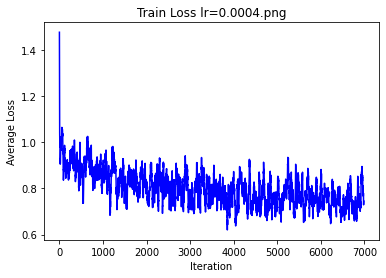

In [55]:
train(lr=0.0004, pickle_title="rcnn004", load=None, batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 0.8227800726890564
Iteration #20 loss: 0.9270854592323303
Iteration #30 loss: 1.2874234914779663
Iteration #40 loss: 0.7592083811759949
Iteration #50 loss: 0.7207939624786377
Iteration #60 loss: 2.236077070236206
Iteration #70 loss: 0.9836193919181824
Iteration #80 loss: 0.754644513130188
Iteration #90 loss: 0.6113879084587097
Iteration #100 loss: 1.3937410116195679
Iteration #110 loss: 0.5909354090690613
Iteration #120 loss: 0.6183595061302185
Iteration #130 loss: 1.0481332540512085
Iteration #140 loss: 0.7361700534820557
Iteration #150 loss: 1.4020589590072632
Iteration #160 loss: 0.821792721748352
Iteration #170 loss: 0.8312845826148987
Iteration #180 loss: 0.7635370492935181
Iteration #190 loss: 0.8968381285667419
Iteration #200 loss: 0.8806568384170532
Iteration #210 loss: 1.003132700920105
Iteration #220 loss: 1.0669126510620117
Iteration #

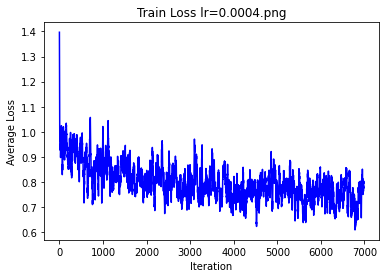

In [57]:
train(lr=0.0004, pickle_title="rcnn006", load="rcnn005", batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 1.0525507926940918
Iteration #20 loss: 0.8168210983276367
Iteration #30 loss: 0.6211452484130859
Iteration #40 loss: 0.8270342350006104
Iteration #50 loss: 1.1324076652526855
Iteration #60 loss: 0.8332163095474243
Iteration #70 loss: 0.8687934875488281
Iteration #80 loss: 0.9338346123695374
Iteration #90 loss: 0.9290810823440552
Iteration #100 loss: 0.8501453995704651
Iteration #110 loss: 0.7982563972473145
Iteration #120 loss: 0.8954468965530396
Iteration #130 loss: 0.9220060706138611
Iteration #140 loss: 1.1099458932876587
Iteration #150 loss: 1.3353211879730225
Iteration #160 loss: 0.7461540699005127
Iteration #170 loss: 0.6018044352531433
Iteration #180 loss: 0.6657125353813171
Iteration #190 loss: 0.7649400234222412
Iteration #200 loss: 0.5620690584182739
Iteration #210 loss: 1.0866448879241943
Iteration #220 loss: 0.8171897530555725
Iterati

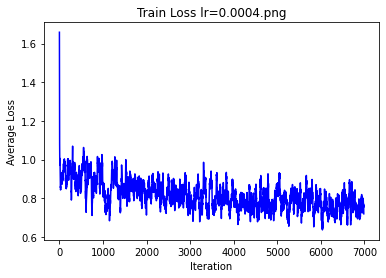

In [58]:
train(lr=0.0004, pickle_title="rcnn007", load="rcnn006", batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 0.8596133589744568
Iteration #20 loss: 1.006596326828003
Iteration #30 loss: 0.9782651662826538
Iteration #40 loss: 0.995775043964386
Iteration #50 loss: 0.841098964214325
Iteration #60 loss: 0.9848833680152893
Iteration #70 loss: 1.076197624206543
Iteration #80 loss: 1.0126374959945679
Iteration #90 loss: 0.5730016231536865
Iteration #100 loss: 0.9104631543159485
Iteration #110 loss: 0.7019206285476685
Iteration #120 loss: 0.6533551812171936
Iteration #130 loss: 1.1847182512283325
Iteration #140 loss: 0.8495867848396301
Iteration #150 loss: 0.6767448782920837
Iteration #160 loss: 0.9005364775657654
Iteration #170 loss: 0.6959843039512634
Iteration #180 loss: 1.1206609010696411
Iteration #190 loss: 0.6588346362113953
Iteration #200 loss: 0.9099961519241333
Iteration #210 loss: 0.6396613717079163
Iteration #220 loss: 0.48104730248451233
Iteration 

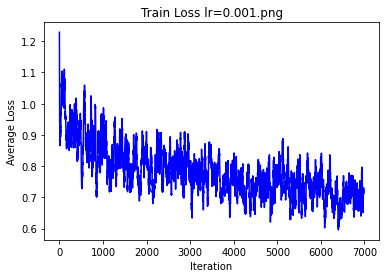

In [59]:
train(lr=0.001, pickle_title="rcnn008", load="rcnn007", batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 0.8871439099311829
Iteration #20 loss: 0.848147988319397
Iteration #30 loss: 0.661910891532898
Iteration #40 loss: 1.6804033517837524
Iteration #50 loss: 0.7634296417236328
Iteration #60 loss: 1.0736089944839478
Iteration #70 loss: 0.9843361973762512
Iteration #80 loss: 1.0157567262649536
Iteration #90 loss: 0.9570796489715576
Iteration #100 loss: 0.8470216989517212
Iteration #110 loss: 0.9227045774459839
Iteration #120 loss: 1.1624934673309326
Iteration #130 loss: 1.16593337059021
Iteration #140 loss: 1.5861461162567139
Iteration #150 loss: 1.3424192667007446
Iteration #160 loss: 1.1029785871505737
Iteration #170 loss: 0.7426373958587646
Iteration #180 loss: 0.6076832413673401
Iteration #190 loss: 1.3388311862945557
Iteration #200 loss: 0.7489522695541382
Iteration #210 loss: 0.8630680441856384
Iteration #220 loss: 0.970475971698761
Iteration #2

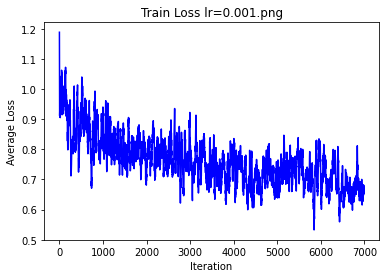

In [63]:
train(lr=0.001, pickle_title="rcnn0010", load="rcnn009", batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [ ]:
train(lr=0.002, pickle_title="rcnn0013", load="rcnn0012", batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
groundtruths removed
groundtruths successfully created
starting train
Iteration #10 loss: 0.8505813479423523
Iteration #20 loss: 0.5325974225997925
Iteration #30 loss: 0.7140417098999023
Iteration #40 loss: 0.8495182991027832
Iteration #50 loss: 1.0449848175048828
Iteration #60 loss: 0.7368888854980469
Iteration #70 loss: 0.891355037689209
Iteration #80 loss: 0.5360661149024963
Iteration #90 loss: 0.9769984483718872
Iteration #100 loss: 1.2846136093139648
Iteration #110 loss: 1.3717684745788574
Iteration #120 loss: 0.9750264883041382
Iteration #130 loss: 0.9729995131492615
Iteration #140 loss: 0.7196092009544373
Iteration #150 loss: 0.9172197580337524
Iteration #160 loss: 0.49013444781303406
Iteration #170 loss: 0.8401777744293213
Iteration #180 loss: 0.9406200647354126
Iteration #190 loss: 0.7866979837417603
Iteration #200 loss: 0.741022527217865
Iteration #210 loss: 0.40837642550468445
Iteration #220 loss: 1.2320516109466553
Iterati

In [ ]:
train(lr=0.0003, pickle_title="rcnn005", load=None, batch_size=4)
%cd ./data/
!python ./pascalvoc.py
%cd ..

In [43]:
!pip install tqdm 

In [46]:
import torch
import time
from torch.utils.data import DataLoader
import math
import matplotlib.pyplot as plt
import os
import shutil
import sys

def evaluate(lr=0.0005, batch_size=4, plt_title="Train Loss", pickle_title="rcnn", TEST=False, load=None):
  """
  Citation:
    https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
    Pytorch Official Documentation, Torchvision Intermediate Tutorial
    Object Detection Finetuning Tutorial
  """
  if(torch.cuda.is_available()):
      device = torch.device("cuda")
      print(device, torch.cuda.get_device_name(0))
  else:
      device= torch.device("cpu")
      print(device)

  def collate(batch):
      return tuple(zip(*batch))

  s = time.time()
  
  model = get_model(pretrained=True).to(device)
  dataset = VinBigDataset()
  if plt_title == "Train Loss":
    plt_title +=" lr=" + str(lr) + '.png'
  shuffle = True
  
  if TEST:
    keep_len = math.floor(.05 * len(dataset))
    throwaway = len(dataset) - keep_len

    keep, throwaway = torch.utils.data.random_split(dataset, [keep_len, throwaway])

    dlen = len(keep)
    train_len = math.floor(dlen * 0.8)
    val_len = dlen - train_len

    train, val = torch.utils.data.random_split(keep, [train_len, val_len])
    train_len_2 = math.floor(train_len * 0.8)
    test_len = train_len - train_len_2
    train, test = torch.utils.data.random_split(train, [train_len_2, test_len])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
  else:
    dlen = len(dataset)
    train_len = math.floor(dlen - 3000)
    val_len = 3000
    train, val = torch.utils.data.random_split(dataset, [train_len, val_len])
    train_len_2 = math.floor(train_len * 0.8)
    test_len = train_len - train_len_2
    train, test = torch.utils.data.random_split(train, [train_len_2, test_len])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
  params = [p for p in model.parameters() if p.requires_grad]
  optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)
  
  # create_ground(val_loader, dataset)
  
#   print(dataset.image_ids_inverse[dataset[0][1]["image_id"].item()])
  
  
#   test_val = torch.utils.data.Subset(dataset, [i for i in range(0, 16)])
#   test_train = torch.utils.data.Subset(dataset, [i for i in range(0, 16)])
  
#   test_train_loader = DataLoader(test_train, batch_size=2, shuffle=True, collate_fn=collate)
#   test_val_loader = DataLoader(test_val, batch_size=2, shuffle=True, collate_fn=collate)

  print("starting train")
  
  # EPOCHS = 5
  # itr = 1
  
  # losses = []
  # losses_val = []
  # avg_loss = []
  # avg_loss_val = []

  # num_itr = 25

  # for i in range(EPOCHS):
  #   model.train()
  #   for images, targets in train_loader:
  #     images = list(image.to(device) for image in images)
  #     targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
  #     loss = model(images, targets)
  #     loss = sum(l for l in loss.values())
  #     losses.append(loss)
  #     if itr > num_itr:
  #       avg_loss.append(sum(losses[itr-num_itr:itr]) / num_itr)
      
  #     if itr % 10 == 0:
  #       print(f"Iteration #{itr} loss: {loss.item()}")
      
  #     optimizer.zero_grad()
  #     loss.backward()
  #     optimizer.step()
      
  #     itr += 1
  #   lr_scheduler.step()


  # torch.save(model, './' + pickle_title)


  model.eval()
  # print("Test")
  # try:
  #   shutil.rmtree('./data/detections')
  #   print("detections removed and recreated")
  # except OSError as e:
  #   print ("Error: %s - %s." % (e.filename, e.strerror))



  for images, targets in val_loader:
    images = list(image.to(device) for image in images)
    output = model(images)
    outputs = [{k:v.to(device) for k,v in t.items()} for t in output]
    # measure(targets, outputs, dataset)
    
    
  print("Time:")
  print(time.time() - s)
  
#   plt.plot(losses)
# #   plt.savefig("Losses.png")
  
#   plt.figure()
#   plt.plot(avg_loss, color='blue', label="train")
#   plt.plot(avg_loss_val, color='red', label="validation")
#   plt.title(plt_title)
#   plt.xlabel("Iteration")
#   plt.ylabel("Average Loss")
#   plt.savefig(plt_title)
  
      
# train()

In [47]:
evaluate(load="rcnn03")

cuda Tesla V100-SXM2-16GB
cuda Tesla V100-SXM2-16GB
starting train
Time:
107.43029403686523


In [48]:
!glxinfo

/bin/bash: glxinfo: command not found


In [49]:
!lshw -C display

/bin/bash: lshw: command not found


In [52]:
!nvidia-smi > file.log